# CMSE 802 In-class assignment: Artificial Neutral Networks Part 2
## Date: 11/13/2018
## Due: 11/13/2018; 10:30 PM

### The goal of this assignment is to learn more about ANN and use existing modules and libraries.

<img src= "https://ml4a.github.io/images/temp_fig_mnist.png" width="80%">
<p style="text-align: right;">From: Machine Learning for Artists - https://ml4a.github.io/</p>

---
### Your name: Boyao Zhu

---

### 1. Forward feeding and backward propagation in ANN:

We will use the code, partSix.py, provided in the "Neural Networks Demystified" module which can be downloaded from github:

    git clone https://github.com/stephencwelch/Neural-Networks-Demystified

In [1]:
# Neural Networks Demystified
# Part 6: Training
#
# Supporting code for short YouTube series on artificial neural networks.
#
# Stephen Welch
# @stephencwelch

## ----------------------- Part 1 ---------------------------- ##
import numpy as np


## ----------------------- Part 5 ---------------------------- ##

class Neural_Network(object):
    def __init__(self, ILS = 2, OLS = 1, HLS = 3):        
        #Define Hyperparameters
        self.inputLayerSize = ILS
        self.outputLayerSize = OLS
        self.hiddenLayerSize = HLS
        
        #Weights (parameters)
        self.W1 = np.random.randn(self.inputLayerSize,self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize,self.outputLayerSize)
        
    def forward(self, X):
        #Propogate inputs though network
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        yHat = self.sigmoid(self.z3) 
        return yHat
        
    def sigmoid(self, z):
        #Apply sigmoid activation function to scalar, vector, or matrix
        return 1/(1+np.exp(-z))
    
    def sigmoidPrime(self,z):
        #Gradient of sigmoid
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def costFunction(self, X, y):
        #Compute cost for given X,y, use weights already stored in class.
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)
        return J
        
    def costFunctionPrime(self, X, y):
        #Compute derivative with respect to W and W2 for a given X and y:
        self.yHat = self.forward(X)
        
        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        dJdW2 = np.dot(self.a2.T, delta3)
        
        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        dJdW1 = np.dot(X.T, delta2)  
        
        return dJdW1, dJdW2
    
    #Helper Functions for interacting with other classes:
    def getParams(self):
        #Get W1 and W2 unrolled into vector:
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params
    
    def setParams(self, params):
        #Set W1 and W2 using single paramater vector.
        W1_start = 0
        W1_end = self.hiddenLayerSize * self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], (self.inputLayerSize , self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end], (self.hiddenLayerSize, self.outputLayerSize))
        
    def computeGradients(self, X, y):
        dJdW1, dJdW2 = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))

    def computeNumericalGradient(N, X, y):
        paramsInitial = N.getParams()
        numgrad = np.zeros(paramsInitial.shape)
        perturb = np.zeros(paramsInitial.shape)
        e = 1e-4

        for p in range(len(paramsInitial)):
            #Set perturbation vector
            perturb[p] = e
            N.setParams(paramsInitial + perturb)
            loss2 = N.costFunction(X, y)
            
            N.setParams(paramsInitial - perturb)
            loss1 = N.costFunction(X, y)

            #Compute Numerical Gradient
            numgrad[p] = (loss2 - loss1) / (2*e)

            #Return the value we changed to zero:
            perturb[p] = 0
            
        #Return Params to original value:
        N.setParams(paramsInitial)

        return numgrad 
        
## ----------------------- Part 6 ---------------------------- ##
from scipy import optimize


class trainer(object):
    def __init__(self, N):
        #Make Local reference to network:
        self.N = N
        
    def callbackF(self, params):
        self.N.setParams(params)
        self.J.append(self.N.costFunction(self.X, self.y))   
        
    def costFunctionWrapper(self, params, X, y):
        self.N.setParams(params)
        cost = self.N.costFunction(X, y)
        grad = self.N.computeGradients(X,y)
        return cost, grad
        
    def train(self, X, y, maxiter=2000):
        #Make an internal variable for the callback function:
        self.X = X
        self.y = y

        #Make empty list to store costs:
        self.J = []
        
        params0 = self.N.getParams()

        options = {'maxiter': maxiter, 'disp' : True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, jac=True, method='BFGS', \
                                 args=(X, y), options=options, callback=self.callbackF)

        self.N.setParams(_res.x)
        self.optimizationResults = _res

**Input data. **

In [2]:
# X = (hours sleeping, hours studying), y = Score on test
X = np.array(([3,5], [5,1], [10,2]), dtype=float)
y = np.array(([75], [82], [93]), dtype=float)

print(y.shape)

# Normalize
X = X/np.amax(X, axis=0)
y = y/100 #Max test score is 100

(3, 1)


In [3]:
#Untrained Random Network

NN = Neural_Network()
y1 = NN.forward(X)
print("Untrained Output \n", y1)

Untrained Output 
 [[0.60216276]
 [0.59199143]
 [0.57881643]]


** Train the network. **

In [4]:
#Training step

T = trainer(NN)
T.train(X,y)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 50
         Function evaluations: 52
         Gradient evaluations: 52


In [5]:
#Trained Network

y2 = NN.forward(X)
print("Trained Output \n",y2)

Trained Output 
 [[0.75003818]
 [0.81994715]
 [0.9300063 ]]


**Calculate the MSE for the untrained and trained neutral networks. **

In [10]:
# Your code:

ut_err = np.linalg.norm(y-y1,ord='fro') # <== fill the blank
t_err = np.linalg.norm(y-y2,ord='fro')   # <== fill the blank

print("Untrained error \n", ut_err)
print("Trained error \n", t_err)

Untrained error 
 0.44404240664031497
Trained error 
 6.550218596592588e-05


---
### 2. Use ANN on the "Digits" dataset.

Here is the code copied from the Machine Learning Module which downloads the "digits" dataset and separates it into training and testing sets. 

In [83]:
import matplotlib.pylab as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.cross_validation import train_test_split

sk_data = load_digits();

feature_vectors = sk_data.data
class_labels = sk_data.target
categories = sk_data.target_names

N, h, w = sk_data.images.shape
train_vectors, test_vectors, train_labels, test_labels = \
train_test_split(feature_vectors, class_labels, test_size=0.25, random_state=1)

In [12]:
# Cool slider to browse all of the images.
from ipywidgets import interact

def browse_images(images, labels, categories):
    n = len(images)
    def view_image(i):
        plt.imshow(images[i], cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title('%s' % categories[labels[i]])
        plt.axis('off')
        plt.show()
    interact(view_image, i=(0,n-1))
    
browse_images(sk_data.images, sk_data.target, sk_data.target_names)

interactive(children=(IntSlider(value=898, description='i', max=1796), Output()), _dom_classes=('widget-intera…

* For this new input to work, you need to transform the training and testing data into a format that can work with the class that was developed. 
* Use functions such as ```type``` and ```shape``` to figure out how to transform the data into inputs suitable for training the Neural Network.
* Make sure your inputs and outputs are normalized between zero (0) and one (1).
* Modify the number of Input, Output and Hidden layers to match the new problem. 
  

In [84]:
# Your code:
print (feature_vectors.shape)
print (class_labels.shape)
print (categories)

print (feature_vectors.dtype)
print (class_labels.dtype)
print (categories.dtype)

train_vectors_norm = train_vectors/16
test_vectors_norm = test_vectors/16
train_labels_norm = train_labels/10
train_labels_norm = train_labels_norm.reshape((1347,1))
test_labels_norm = test_labels/10 
test_labels_norm = test_labels_norm.reshape((450,1))
#print (test_labels_norm.shape)
print (train_vectors_norm)
print (train_vectors_norm.shape)
print (train_labels_norm.shape)

(1797, 64)
(1797,)
[0 1 2 3 4 5 6 7 8 9]
float64
int64
int64
[[ 0.  0.  7. ...  3.  0.  0.]
 [ 0.  0.  0. ... 11.  6.  0.]
 [ 0.  0.  0. ...  9.  0.  0.]
 ...
 [ 0.  0.  7. ... 13.  2.  0.]
 [ 0.  0.  0. ... 16.  1.  0.]
 [ 0.  0.  8. ...  0.  0.  0.]]
[[0.     0.     0.4375 ... 0.1875 0.     0.    ]
 [0.     0.     0.     ... 0.6875 0.375  0.    ]
 [0.     0.     0.     ... 0.5625 0.     0.    ]
 ...
 [0.     0.     0.4375 ... 0.8125 0.125  0.    ]
 [0.     0.     0.     ... 1.     0.0625 0.    ]
 [0.     0.     0.5    ... 0.     0.     0.    ]]
(1347, 64)
(1347, 1)


In [85]:
#Run the training. 

NN = Neural_Network(ILS=64 , OLS= 1 , HLS= 10) # <== fill the blank
T = trainer(NN)
T.train(train_vectors_norm, train_labels_norm)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in square


         Current function value: 1.158959
         Iterations: 1280
         Function evaluations: 1316
         Gradient evaluations: 1305


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in square
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


** Evaluate training and testing data errors. **

In [87]:
pred_labels = NN.forward(train_vectors_norm)

# Training data error
train_err = np.linalg.norm(train_labels_norm-pred_labels,ord='fro')  # <== fill the blank

print("Training Data error", train_err)



pred_labels = NN.forward(test_vectors_norm)

# Testing data error
test_err = np.linalg.norm(test_labels_norm-pred_labels,ord='fro')   # <== fill the blank

print("Testing Data error", test_err)


Training Data error 1.522471000765278
Testing Data error 2.9477783178054966


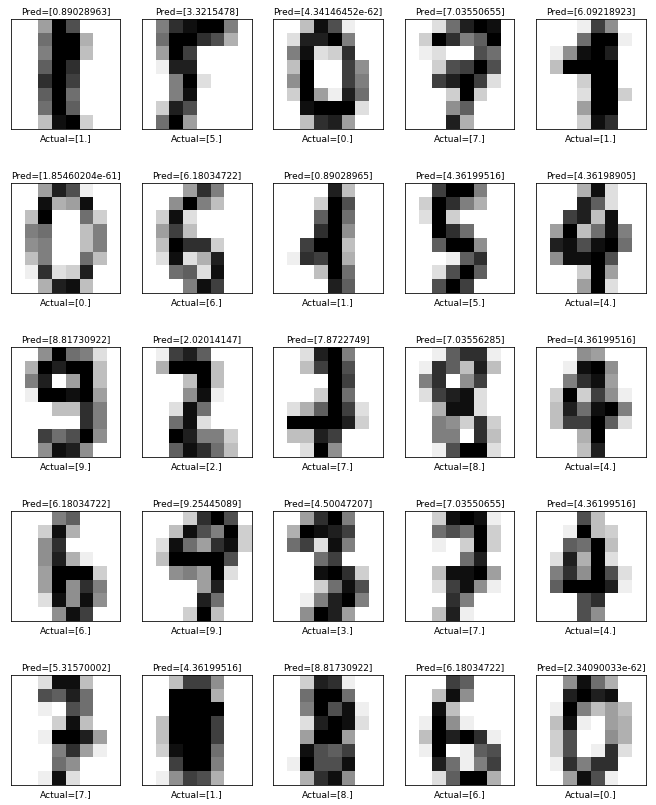

In [88]:
def plot_gallery(images, true_titles, pred_titles, h, w, n_row=5, n_col=5):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray_r)
        plt.title('Pred='+str(pred_titles[i]*10), size=9)
        plt.xlabel('Actual='+str(true_titles[i]*10), size=9)
        plt.xticks(())
        plt.yticks(())

    plt.show()
    
plot_gallery(test_vectors, test_labels_norm, pred_labels, h,w)

---
### 3. sklearn library for neutral network.

In this section we will repeat the example of Digits using a neural network function in python machine learning library: sklearn. ** Investigate sklearn.neural_network( ) and MLPRegressor. Use MLPRegressor to repeat the tasks for recognizing Digits above. ** In this task, you do not need to normalize the data.

In [96]:
# Your code:
from sklearn.neural_network import MLPRegressor

X_train, X_test, y_train, y_test = train_test_split(feature_vectors, class_labels, test_size= 0.25, random_state=42)
mlp = MLPRegressor(random_state=0).fit(X_train, y_train)

print (X_train.shape)
print (X_test.shape)

(1347, 64)
(450, 64)


** Evaluate training and testing data errors.**

In [100]:
pred_labels = mlp.predict(X_train)

# Training data error
train_err = np.linalg.norm(y_train-pred_labels)  # <== fill the blank

print("Training Data error", train_err)


pred_labels = mlp.predict(X_test)

# Testing data error
test_err = np.linalg.norm(y_test-pred_labels)    # <== fill the blank

print("Testing Data error", test_err)

Training Data error 32.11090640150321
Testing Data error 24.675848904606283


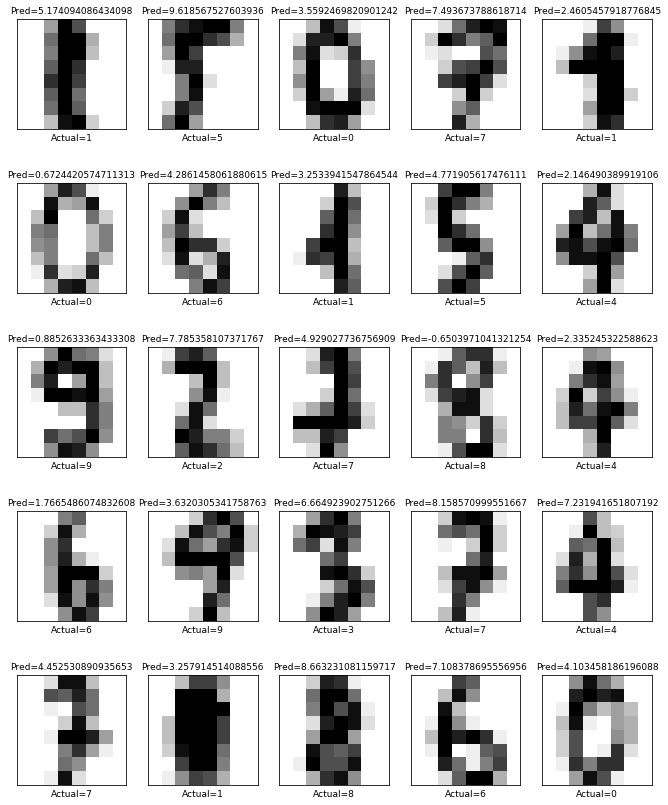

In [101]:
def plot_gallery_2(images, true_titles, pred_titles, h, w, n_row=5, n_col=5):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray_r)
        plt.title('Pred='+str(pred_titles[i]), size=9)
        plt.xlabel('Actual='+str(true_titles[i]), size=9)
        plt.xticks(())
        plt.yticks(())

    plt.show()
    
plot_gallery_2(test_vectors, test_labels, pred_labels, h,w)

---
### Congratulations, we're done!

** Don't forget to add your names to the top!!**

Log into the course D2L website (d2l.msu.edu) and go to "Assessments > Assignments > In-class Assignment 20181113".